<a href="https://colab.research.google.com/github/basmadokkar/CV/blob/main/DenseUNet_CD_ONERA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff
import glob
import os
import cv2
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model
from keras.applications import DenseNet121
from keras.layers import Input,Dense,Reshape,Flatten,Input,GlobalAveragePooling2D,Conv2D,MaxPool2D,BatchNormalization,Conv2DTranspose,concatenate,UpSampling2D
from keras import optimizers
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras import backend as K
from sklearn import metrics
from google.colab import drive

from keras.preprocessing.image import ImageDataGenerator
from skimage.filters import threshold_otsu, threshold_multiotsu
from cv2 import adaptiveThreshold
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from keras.models import Model
from keras.layers import Dropout, Activation, Reshape

In [2]:
from keras.layers import Conv2D, Conv2DTranspose,UpSampling2D
from keras.layers import AveragePooling2D
#from keras.layers import merge
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.utils import get_source_inputs
# from keras_applications.imagenet_utils import _obtain_input_shape
import keras.backend as K

In [3]:
import tensorflow as tf

def binary_crossentropy(Y_pred, Y_gt):
    epsilon = 1.e-5
    Y_pred = tf.clip_by_value(Y_pred, epsilon, 1. - epsilon)
    logits = tf.log(Y_pred / (1 - Y_pred))
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y_gt, logits=logits)
    loss = tf.reduce_mean(loss)
    return loss


def dice_loss_3d(Y_gt, Y_pred):
    Z, H, W, C = Y_gt.get_shape().as_list()[1:]
    smooth = 1e-5
    pred_flat = tf.reshape(Y_pred, [-1, H * W * C * Z])
    true_flat = tf.reshape(Y_gt, [-1, H * W * C * Z])
    intersection = 2 * tf.reduce_sum(pred_flat * true_flat, axis=1) + smooth
    denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + smooth
    loss = 1 - tf.reduce_mean(intersection / denominator)
    return loss


def dice_loss_2d(Y_gt, Y_pred):
    H, W, C = Y_gt.get_shape().as_list()[1:]
    smooth = 1e-5
    pred_flat = tf.reshape(Y_pred, [-1, H * W * C])
    true_flat = tf.reshape(Y_gt, [-1, H * W * C])
    intersection = 2 * tf.reduce_sum(pred_flat * true_flat, axis=1) + smooth
    denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + smooth
    loss = 1 - tf.reduce_mean(intersection / denominator)
    return loss


def tversky_loss_3d(Y_gt, Y_pred, alpha=0.7):
    Z, H, W, C = Y_gt.get_shape().as_list()[1:]
    smooth = 1e-5
    y_pred_pos = tf.reshape(Y_pred, [-1, H * W * C * Z])
    y_true_pos = tf.reshape(Y_gt, [-1, H * W * C * Z])
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos, axis=1)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos), axis=1)
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos, axis=1)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)
    loss = 1 - tf.reduce_mean(tversky)
    return loss


def tversky_loss_2d(Y_gt, Y_pred, alpha=0.7):
    H, W, C = Y_gt.get_shape().as_list()[1:]
    smooth = 1e-5
    y_pred_pos = tf.reshape(Y_pred, [-1, 256*256*3])
    y_true_pos = tf.reshape(Y_gt, [-1, 256*256*3])
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos, axis=1)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos), axis=1)
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos, axis=1)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)
    loss = 1 - tf.reduce_mean(tversky)
    return loss


def focal_tversky_3d(Y_gt, Y_pred, alpha=0.7, gamma=0.75):
    Z, H, W, C = Y_gt.get_shape().as_list()[1:]
    smooth = 1e-5
    y_pred_pos = tf.reshape(Y_pred, [-1, H * W * C * Z])
    y_true_pos = tf.reshape(Y_gt, [-1, H * W * C * Z])
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos, axis=1)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos), axis=1)
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos, axis=1)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)
    loss = 1 - tf.reduce_mean(tversky)
    loss = tf.pow(loss, gamma)
    return loss


def focal_tversky_2d(Y_gt, Y_pred, alpha=0.7, gamma=0.75):
    H, W, C = Y_gt.get_shape().as_list()[1:]
    smooth = 1e-5
    y_pred_pos = tf.reshape(Y_pred, [-1, 3*256*256])
    y_true_pos = tf.reshape(Y_gt, [-1, 3*256*256])
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos, axis=1)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos), axis=1)
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos, axis=1)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)
    loss = 1 - tf.reduce_mean(tversky)
    loss = tf.pow(loss, gamma)
    return loss


def generalised_dice_loss_3d(Y_gt, Y_pred):
    smooth = 1e-5
    w = tf.reduce_sum(Y_gt, axis=[1, 2, 3])
    w = 1 / (w ** 2 + smooth)

    numerator = Y_gt * Y_pred
    numerator = w * tf.reduce_sum(numerator, axis=[1, 2, 3])
    numerator = tf.reduce_sum(numerator, axis=1)

    denominator = Y_pred + Y_gt
    denominator = w * tf.reduce_sum(denominator, axis=[1, 2, 3])
    denominator = tf.reduce_sum(denominator, axis=1)

    gen_dice_coef = 2 * numerator / (denominator + smooth)
    loss = tf.reduce_mean(1 - gen_dice_coef)
    return loss


def generalised_dice_loss_2d_ein(Y_gt, Y_pred):
    Y_gt = tf.cast(Y_gt, 'float32')
    Y_pred = tf.cast(Y_pred, 'float32')
    w = tf.einsum("bwhc->bc", Y_gt)
    w = 1 / ((w + 1e-10) ** 2)
    intersection = w * tf.einsum("bwhc,bwhc->bc", Y_pred, Y_gt)
    union = w * (tf.einsum("bwhc->bc", Y_pred) + tf.einsum("bwhc->bc", Y_gt))

    divided = 1 - 2 * (tf.einsum("bc->b", intersection) + 1e-10) / (tf.einsum("bc->b", union) + 1e-10)

    loss = tf.reduce_mean(divided)
    return loss


def generalised_dice_loss_2d(Y_gt, Y_pred):
    smooth = 1e-5
    w = tf.reduce_sum(Y_gt, axis=[1, 2])
    w = 1 / (w ** 2 + smooth)

    numerator = Y_gt * Y_pred
    numerator = w * tf.reduce_sum(numerator, axis=[1, 2])
    numerator = tf.reduce_sum(numerator, axis=1)

    denominator = Y_pred + Y_gt
    denominator = w * tf.reduce_sum(denominator, axis=[1, 2])
    denominator = tf.reduce_sum(denominator, axis=1)

    gen_dice_coef = 2 * numerator / (denominator + smooth)
    loss = tf.reduce_mean(1 - gen_dice_coef)
    return loss


def surface_loss_3d(Y_gt, Y_pred):
    multipled = tf.reduce_sum(Y_gt * Y_pred, axis=[0,1, 2, 3, 4])
    loss = tf.reduce_mean(multipled)
    return loss


def surface_loss_2d(Y_gt, Y_pred):
    multipled = tf.reduce_sum(Y_gt * Y_pred, axis=[0,1, 2, 3])
    loss = tf.reduce_mean(multipled)
    return loss


def focal_loss_sigmodv1(Y_gt, Y_pred,alpha=0.25, gamma=2):
   epsilon = 1e-5
   pt_1 = tf.where(tf.equal(Y_gt, 1), Y_pred, tf.ones_like(Y_pred))
   pt_0 = tf.where(tf.equal(Y_gt, 0), Y_pred, tf.zeros_like(Y_pred))
   # clip to prevent NaN's and Inf's
   pt_1 = tf.clip_by_value(pt_1, epsilon, 1. - epsilon)
   pt_0 = tf.clip_by_value(pt_0, epsilon, 1. - epsilon)
   loss_1 = -alpha * tf.pow(1. - pt_1, gamma) * tf.log(pt_1)
   loss_0 = -(1 - alpha) * tf.pow(pt_0, gamma) * tf.log(1. - pt_0)
   loss = tf.reduce_sum(loss_1 + loss_0)
   return loss

x = tf.constant(value=5., shape=(3, 32, 32, 32, 1))
y = tf.constant(value=1., shape=(3, 32, 32, 32, 1))
surface_loss_3d(x, y)

<tf.Tensor: shape=(), dtype=float32, numpy=491520.0>

In [4]:
phisycal_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num of GPUs available: ",len(phisycal_devices))

# options = tf.config.experimental.set_memory_growth(phisycal_devices[0] , True)

Num of GPUs available:  1


In [5]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
!ls /content/drive/MyDrive/New_data_diff_image/

'adam_777_image_65epoch_diff_img (1).hdf5'   Avarange_intencty	 FUZZY_min_NDBI_DI   onera.zip
 adam_777_image_65epoch_diff_img.hdf5	     diff_img		 mask1
 adam_777_image_65epoch_FUZZY_NDBI_DI.hdf5   Fusion_Fuzzy_min	 NDBI
 adam_777_image_65epoch_Fuzzyset_min.hdf5    Fuzzy_DI_AI_min	 New_Fusion1


In [7]:
%%time
train_images_diff,i = [],0
for directory_path in glob.glob("/content/drive/MyDrive/New_data_diff_image/diff_img"):
    for img_path1 in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        imgs1 = cv2.imread(img_path1, cv2.IMREAD_COLOR)
        imgs1=imgs1.astype('float32')
        train_images_diff.append(imgs1)
#         i += 1
#         if i == 775:
#             break
#Convert list to array for machine learning processing
X1 = np.array(train_images_diff)
X1 = np.expand_dims(X1, -1)
X1 = X1/255.0
X1.shape
# train_images_diff = 0

CPU times: user 2.06 s, sys: 882 ms, total: 2.95 s
Wall time: 24.4 s


(777, 256, 256, 3, 1)

In [8]:
X1.shape

(777, 256, 256, 3, 1)

In [9]:
%%time
train_mask = []
J=0
for directory_path in glob.glob("/content/drive/MyDrive/New_data_diff_image/mask1"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        #print(mask_path)
        mask = cv2.imread(mask_path)
        mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_gray=mask_gray.astype('float32')
        # print(mask_gray.shape)
        # plt.imshow(mask_gray)
        train_mask.append(mask_gray)
        # J += 1
        # if J == 775:
        #     break
#Convert list to array for machine learning processing

Y= np.array(train_mask)
train_mask= 0
#Y =Y.reshape((6000,256,256,1))
Y = np.expand_dims(Y, -1)
Y = Y/255.0
Y.shape

CPU times: user 843 ms, sys: 354 ms, total: 1.2 s
Wall time: 18 s


(777, 256, 256, 1)

In [10]:
Y.shape

(777, 256, 256, 1)

In [11]:
print(X1.shape)
print(Y.shape)

(777, 256, 256, 3, 1)
(777, 256, 256, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(582, 256, 256, 3, 1)
(195, 256, 256, 3, 1)


In [13]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_densenet121_unet(input_shape):
    """ Input """
    inputs = Input(input_shape, name="input_1")

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights=None, input_tensor=inputs)

    """ Encoder """

    s1 = densenet.get_layer("input_1").output       ## 512
    s2 = densenet.get_layer("conv1/relu").output    ## 256
    s3 = densenet.get_layer("pool2_relu").output ## 128
    s4 = densenet.get_layer("pool3_relu").output  ## 64

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 32

    """ Decoder """
    d1 = decoder_block(b1, s4, 256)             ## 64
    d2 = decoder_block(d1, s3, 128)             ## 128
    d3 = decoder_block(d2, s2, 64)             ## 256
    d4 = decoder_block(d3, s1, 32)              ## 512

    """ Outputs """
    outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

# def build_densenet121_unet(input_shape):
#     """ Input """
#     inputs = Input(input_shape)

#     """ Pre-trained DenseNet121 Model """
#     densenet = DenseNet121(include_top=False, weights=None, input_tensor=inputs)

#     """ Encoder """
#     s1 = inputs                                       ## 256
#     s2 = densenet.get_layer("conv1/relu").output    ## 256
#     s3 = densenet.get_layer("pool2_relu").output ## 128
#     s4 = densenet.get_layer("pool3_relu").output  ## 64

#     """ Bridge """
#     b1 = densenet.get_layer("pool4_relu").output  ## 32

#     """ Decoder """
#     d1 = decoder_block(b1, s4, 256)             ## 64
#     d2 = decoder_block(d1, s3, 128)             ## 128
#     d3 = decoder_block(d2, s2, 64)             ## 256
#     d4 = decoder_block(d3, s1, 32)              ## 512

#     """ Outputs """
#     outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)

#     model = Model(inputs, outputs)
#     return model



if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_densenet121_unet(input_shape)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

In [14]:
weights = model.get_weights()
A =[]

for w in weights :
    if len(np.array(w).shape) == 1 and len(np.array (w)) == 1:
       A.append(w)
    else:
        F = w.flatten()
        for f in F :
            A.append(f)

In [15]:
np.quantile(np.array(A),0.25),np.quantile(np.array(A),0.5), np.quantile(np.array(A),0.75)

(-0.02220076136291027, 1.9259750843048096e-05, 0.02280690148472786)

565


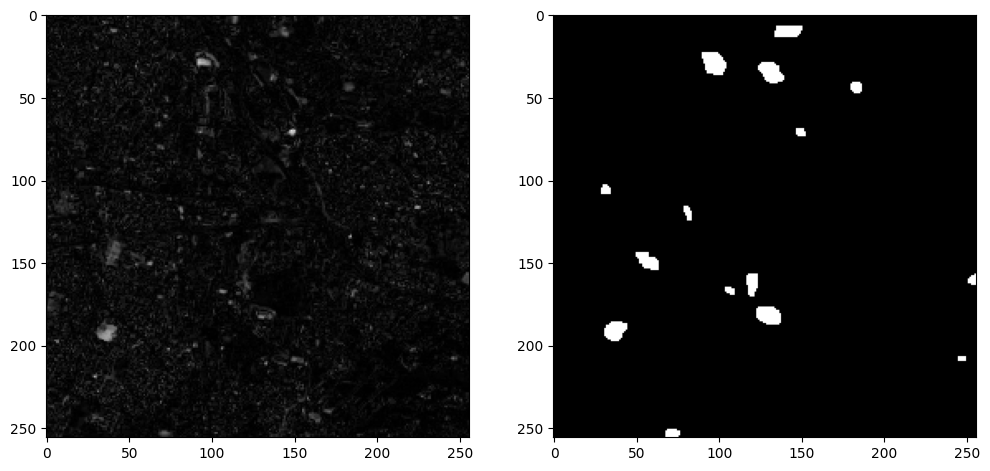

In [16]:
image_number = random.randint(0, len(X_train))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [17]:
%%time
seed=24

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.5,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.5,
                     fill_mode='reflect') #Binarize the output again.

X_train=X_train.reshape(582, 256, 256, 3)
X_test=X_test.reshape(195, 256, 256, 3)
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

CPU times: user 9.6 s, sys: 392 ms, total: 9.99 s
Wall time: 10.2 s


In [18]:
%%time

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

CPU times: user 2.4 s, sys: 108 ms, total: 2.51 s
Wall time: 2.5 s


In [19]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

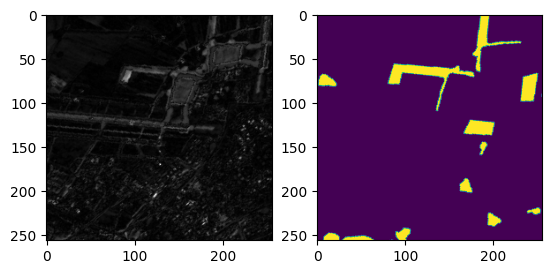

In [20]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
%%time
# model = get_model()
from tensorflow import keras
#@title Select parameters {run: "auto"}

optimizer = 'adam' #@param ["adam" , "momentum" , "rmsprop" , "adagrad", "nag"] {type :"string"}
Learning_rate = 0.0001 #@param {type:"number"}
LR = float(Learning_rate)
if (optimizer=="adagrad"):
  opt = keras.optimizers.Adagrad(learning_rate=LR)
if (optimizer=="adam"):
  opt = keras.optimizers.Adam(learning_rate=LR)
if (optimizer=="RMSprop"):
  opt = keras.optimizers.RMSProp(learning_rate=LR)
if (optimizer=="momentum"):
  opt = keras.optimizers.SGD(learning_rate=LR,momentum=0.9)
if (optimizer=="nag"):
  opt = keras.optimizers.SGD(learning_rate=LR,momentum=0.9,nesterov=True)

batch_size = 64
steps_per_epoch = 3*(len(X_train))//batch_size
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['acc'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(my_generator,
                    validation_data = validation_datagen,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = steps_per_epoch,
                    epochs=200)

Epoch 1/300
27/27 [==============================] - 150s 2s/step - loss: 0.6870 - acc: 0.0091 - val_loss: 0.6902 - val_acc: 2.3566e-07
Epoch 2/300
27/27 [==============================] - 45s 2s/step - loss: 0.5449 - acc: 0.0055 - val_loss: 0.6679 - val_acc: 9.1798e-07
Epoch 3/300
27/27 [==============================] - 65s 2s/step - loss: 0.4756 - acc: 0.0081 - val_loss: 0.6353 - val_acc: 7.9354e-06
Epoch 4/300
27/27 [==============================] - 41s 2s/step - loss: 0.4410 - acc: 0.0051 - val_loss: 0.6078 - val_acc: 1.1748e-04
Epoch 5/300
27/27 [==============================] - 41s 2s/step - loss: 0.4144 - acc: 0.0019 - val_loss: 0.6002 - val_acc: 0.0012
Epoch 6/300
27/27 [==============================] - 42s 2s/step - loss: 0.4003 - acc: 0.0010 - val_loss: 0.5402 - val_acc: 7.3438e-06
Epoch 7/300
27/27 [==============================] - 41s 2s/step - loss: 0.3879 - acc: 7.4223e-04 - val_loss: 0.4582 - val_acc: 1.2240e-07
Epoch 8/300
27/27 [==============================] - 4

In [ ]:
history = model.fit(my_generator,
                    validation_data = validation_datagen,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = steps_per_epoch,
                    epochs=100)

In [ ]:
#plot the training and validation accuracy and loss at each epoch
# batch_size*steps_per_epoch*len(loss)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_number)
prediction = model.predict(test_img_input)
prediction = prediction> threshold_otsu(prediction)
prediction=prediction[0,:,:,0]
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()

In [ ]:
metrics.precision_recall_fscore_support(y_test_metrics,y_pred_metrics,average = 'macro')

In [ ]:
metrics.matthews_corrcoef(y_test_metrics,y_pred_metrics)